1. load dataset in a Jupyter notebook and extract relevant column to be processed

In [4]:
import pandas as pd

data = pd.read_csv("/content/compounds.csv", delimiter=";")

smiles_list = data['smiles'].tolist()
compound_names = data['name'].tolist()

print(data)

                                                name  \
0    Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate   
1  (S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)prop...   
2                                        Etilevodopa   
3                                        Foslevodopa   
4                                         Melevodopa   
5                                    L-DOPA (sodium)   
6                      Tyrosine, 3-hydroxy-O-methyl-   
7                                  3-Methoxytyrosine   

                                  smiles  \
0         CCOC(=O)C(CC1=CC(=C(C=C1)O)O)N   
1       COC(=O)C(CC1=CC(=C(C=C1)O)O)N.Cl   
2         CCOC(=O)C(CC1=CC(=C(C=C1)O)O)N   
3  C1=CC(=C(C=C1CC(C(=O)O)N)O)OP(=O)(O)O   
4          COC(=O)C(CC1=CC(=C(C=C1)O)O)N   
5      C1=CC(=C(C=C1CC(C(=O)O)N)O)O.[Na]   
6          COC1=C(C=C(C=C1)CC(C(=O)O)N)O   
7          COC1=C(C=CC(=C1)CC(C(=O)O)N)O   

                                              pubmed  
0  https://pubchem.ncbi.nlm.nih.gov/compoun

2. compute molecular fingerprints for each compound

In [5]:
!pip install rdkit-pypi

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]

print(f"Generated {len(fingerprints)} fingerprints.")

Generated 8 fingerprints.


* Display molecules

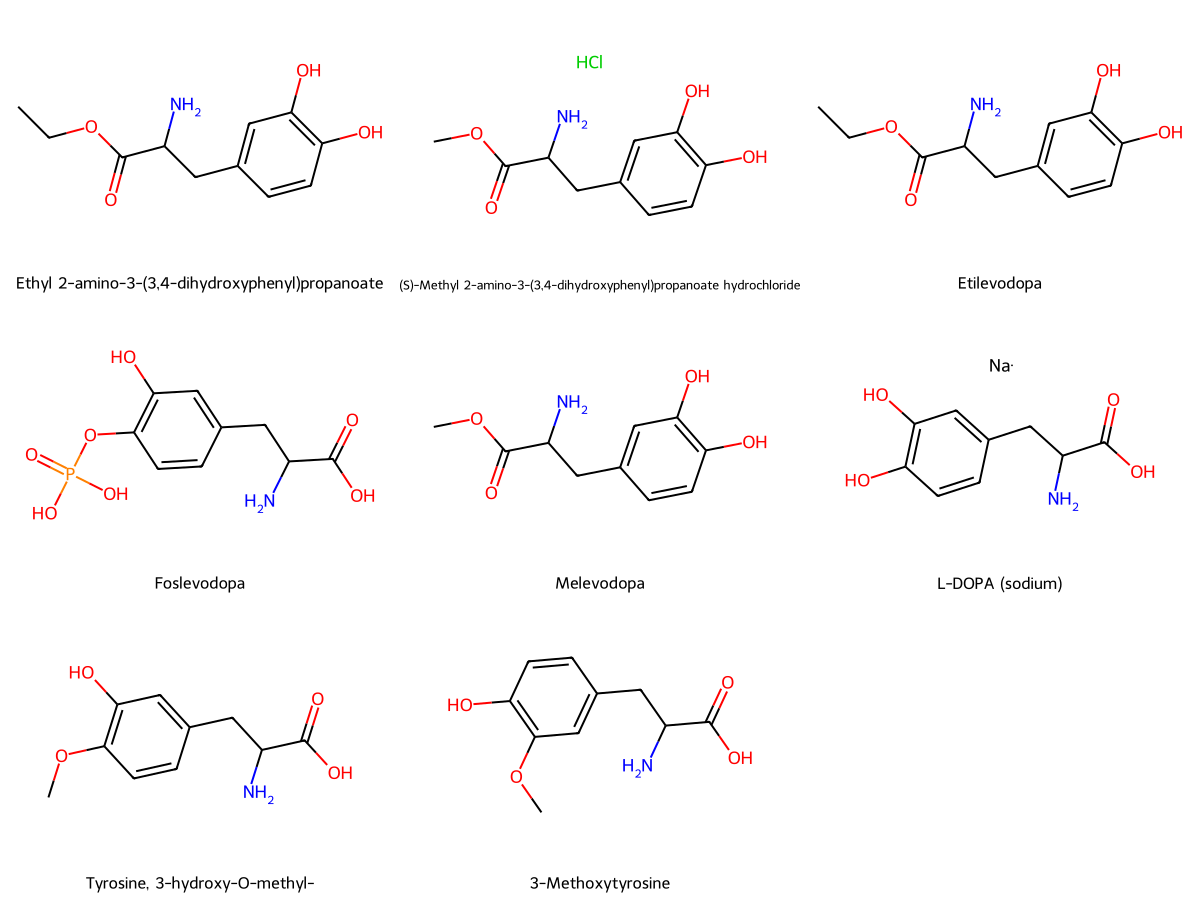

In [14]:
from rdkit.Chem import Draw
from IPython.display import display

img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(400, 300), legends=compound_names)

display(img)

3. compute Tanimoto similarity measure for each pair of compound x reference compound

In [31]:
import numpy as np
import pandas as pd
from rdkit.DataStructs import TanimotoSimilarity

num_compounds = len(fingerprints)
similarity_matrix = np.zeros((num_compounds, num_compounds))

# vypocitem jen pulku, protoze matice je symetricka
for i in range(num_compounds):
    for j in range(i, num_compounds):
        similarity = TanimotoSimilarity(fingerprints[i], fingerprints[j])
        similarity_matrix[j, i] = similarity

df = pd.DataFrame(similarity_matrix, index=compound_names, columns=compound_names)

display(df.style.background_gradient(cmap='Blues').format("{:.2f}"))

,"Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate","(S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride",Etilevodopa,Foslevodopa,Melevodopa,L-DOPA (sodium),"Tyrosine, 3-hydroxy-O-methyl-",3-Methoxytyrosine
"Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate",1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride",0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00
Etilevodopa,1.00,0.73,1.00,0.00,0.00,0.00,0.00,0.00
Foslevodopa,0.45,0.45,0.45,1.00,0.00,0.00,0.00,0.00
Melevodopa,0.75,0.97,0.75,0.46,1.00,0.00,0.00,0.00
L-DOPA (sodium),0.62,0.62,0.62,0.60,0.64,1.00,0.00,0.00
"Tyrosine, 3-hydroxy-O-methyl-",0.51,0.55,0.51,0.68,0.56,0.65,1.00,0.00
3-Methoxytyrosine,0.51,0.55,0.51,0.57,0.56,0.65,0.78,1.00


4. provide sorting, report top 3 hits and discuss your results

In [37]:
similarity_pairs = []

for i in range(1, num_compounds):
    for j in range(i):
        similarity_pairs.append((i, j, similarity_matrix[i, j]))

sorted_pairs = sorted(similarity_pairs, key=lambda x: x[2], reverse=True)
top_3_similarities = sorted_pairs[:3]

for i, j, similarity in top_3_similarities:
    print(f"Similarity: {similarity:.2f}: {compound_names[i]} |X| {compound_names[j]}")

Similarity: 1.00: Etilevodopa |X| Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate
Similarity: 0.97: Melevodopa |X| (S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride
Similarity: 0.78: 3-Methoxytyrosine |X| Tyrosine, 3-hydroxy-O-methyl-


Vypada ze Etilevodopa a Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate maji stejnou strukturu.

(S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride je hydrochloridem Melevedopy